# Discrete Dynamical systems

Overall logic: Although similar to the continuous case, where all systems are Hamiltonian, integration is trivial.

* Define a discrete map and its inverse - limited to 2D maps
* Define a 2D grid to sample points
* Define a common number of iterations
* Iterate map and compute LD function on the fly
* Plot LD map in 2D grid




In [68]:
import numpy as np

In [69]:
def generate_points(GRID_PARAMETERS):
    x_min, x_max, Nx = GRID_PARAMETERS[0]
    y_min, y_max, Ny = GRID_PARAMETERS[1]
    points_x = np.linspace(x_min, x_max, Nx)
    points_y = np.linspace(y_min, y_max, Ny)    
    Y, X = np.meshgrid(points_y, points_x)  # Grid in phase-space
    mesh = np.transpose([X.flatten(), Y.flatten()]) # 2D grid
    return mesh

## Standard map

\begin{align*}
x_{n+1} &= x_n + K sin( y_n ) ,\quad \text{mod } 2\pi \\
y_{n+1} &= y_n + x_{n+1} ,\quad \text{mod } 2\pi
\end{align*}

In [70]:
def StandardMap(u_initial, PARAMETERS=[0.5]):
    """
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x_initial, y_initial = u_initial.T
    # Hamiltonian Model Parameter
    K, = PARAMETERS
    
    # Map components
    x_next = x_initial + K*np.sin(y_initial)
    y_next = y_initial + x_next
    
    # Map next iteration
    u_next = np.array([ x_next, y_next]).T
    u_next = np.mod(u_next, 2*np.pi)
    
    return u_next

In [71]:
GRID_PARAMETERS = [[0, 2*np.pi, 20],[0, 2*np.pi, 20]]

In [72]:
points_original = generate_points(GRID_PARAMETERS)

N_iterations = 200
f = StandardMap

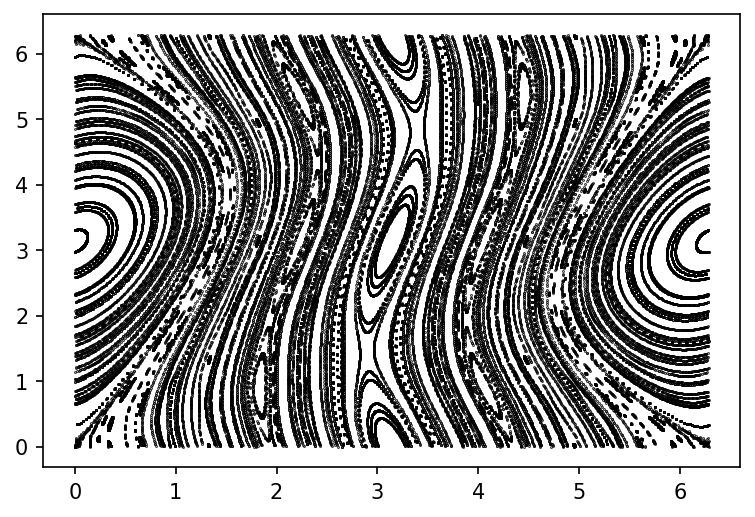

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)

for k in range(len(points_original)):
    points_initial = points_original[k]
    trajectory = []
    for i in range(N_iterations):
        points_next = f(points_initial, PARAMETERS=[0.5])
        trajectory.append(points_next)
        
        points_initial = points_next
        

    plt.scatter(*np.array(trajectory).T,c='k',s=0.1)

plt.show()

## Hènon map

In [98]:
import numpy as np

def HenonMap(u_initial, PARAMETERS=[1.4, 0.3]):
    """
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x_initial, y_initial = u_initial.T
    # Hamiltonian Model Parameter
    a, b = PARAMETERS
    
    # Map components
    x_next = 1 -a*x_initial**2 + y_initial
    y_next = b*x_initial
    
    # Map next iteration
    u_next = np.array([ x_next, y_next]).T
    
    return u_next

In [99]:
GRID_PARAMETERS = [[-1.5, 1.5, 20],[-1.5, 1.5, 20]]

In [100]:
points_original = generate_points(GRID_PARAMETERS)

N_iterations = 10
f = HenonMap

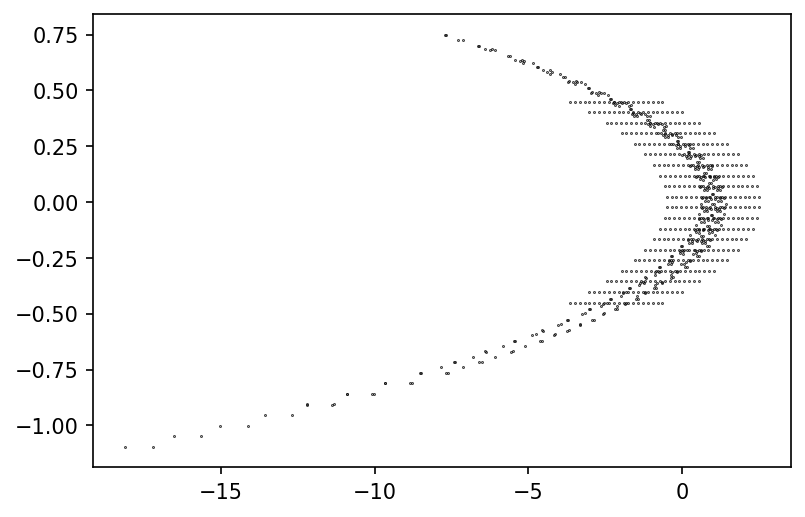

In [103]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)

for k in range(len(points_original)):
    points_initial = points_original[k]
    trajectory = []
    for i in range(2):
        points_next = f(points_initial)
        trajectory.append(points_next)
        
        points_initial = points_next
        
    plt.scatter(*np.array(trajectory).T,c='k',s=0.1)

plt.show()

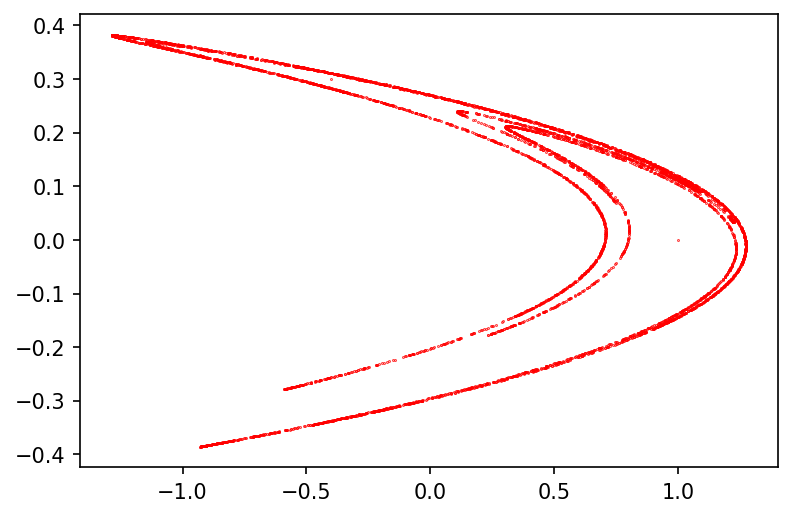

In [122]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)

points_initial = np.array([0,0])

trajectory = []
for i in range(6000):
    points_next = f(points_initial, PARAMETERS=[1.4, 0.3])
#     points_next = f(points_initial, PARAMETERS=[0.2, 0.9991])
    trajectory.append(points_next)
    points_initial = points_next

plt.scatter(*np.array(trajectory).T,c='red',s=0.1)

plt.show()

# Appendix

## Fast recursion using decorators

In [ ]:
def fibonacci_recursive(n):
#     print("Calculating F", "(", n, ")", sep="", end=", ")
    # Base case
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

In [ ]:
fibonacci_recursive(40)

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)
def fibonacci_recursive(n):
#     print("Calculating F", "(", n, ")", sep="", end=", ")

    # Base case
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

In [ ]:
fibonacci_recursive(100)